<a href="https://colab.research.google.com/github/jacobgreen4477/The-4th-ETRI-AI-Human-Understanding-Competition/blob/main/dacon_etri_lifelog_model_vF1_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> title : 제 4회 ETRI 휴먼이해 인공지능 논문경진대회 <br>
> author : hjy,byc <br>

### 📦 라이브러리

In [1]:
! pip install haversine >/dev/null
! pip install optuna  >/dev/null
! pip install category_encoders >/dev/null
! pip install tabpfn  >/dev/null
! pip install catboost >/dev/null
! pip install torchmetrics >/dev/null
# ! rm -rf tabpfn-extensions
# ! git clone https://github.com/priorlabs/tabpfn-extensions.git  >/dev/null
# ! pip install -e tabpfn-extensions  >/dev/null

In [2]:
# 기본 모듈
import os
import sys
import re
import ast
import glob
import random
import warnings
from collections import Counter
from math import radians, cos, sin, asin, sqrt
from functools import reduce
from datetime import datetime, timedelta, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from tabpfn import TabPFNClassifier
# from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from sklearn.inspection import permutation_importance
import shap

# PyTorch
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Hugging Face
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    LlamaTokenizer,
    LlamaForCausalLM,
    LlamaForSequenceClassification
)

# PEFT (Parameter-Efficient Fine-Tuning)
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    TaskType
)

# Evaluation & Utilities
from torchmetrics import Accuracy

# 기타
from tqdm import tqdm
from tqdm.auto import tqdm as auto_tqdm  # 필요 시 구분
from scipy.stats import entropy
from haversine import haversine
from io import StringIO
import gc

# wandb
import wandb
wandb.login(key="5fa8dfb2c5be3c888bfe0101437a8fa22fbdf0e0")
wandb.init(project="etri_lifelog", entity="byc3230")

# 옵션
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

# 기타
warnings.filterwarnings('ignore')

# 기본 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 재현성 향상 옵션 (단, 성능 저하 가능성 있음)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: byc3230 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
string = """
subject_id,sleep_date
id01,2024-07-24
id01,2024-08-26
id01,2024-08-28
id01,2024-08-29
id02,2024-08-23
id02,2024-09-24
id02,2024-09-26
id02,2024-09-27
id03,2024-08-30
id03,2024-09-01
id03,2024-09-02
id03,2024-09-06
id04,2024-09-03
id04,2024-10-10
id04,2024-10-12
id04,2024-10-13
id05,2024-10-19
id05,2024-10-23
id05,2024-10-24
id05,2024-10-27
id06,2024-07-25
id06,2024-07-26
id06,2024-07-27
id06,2024-07-30
id07,2024-07-07
id07,2024-08-02
id07,2024-08-04
id07,2024-08-05
id08,2024-08-28
id08,2024-08-29
id08,2024-08-30
id08,2024-09-02
id09,2024-08-02
id09,2024-08-31
id09,2024-09-02
id09,2024-09-03
id10,2024-08-28
id10,2024-08-30
id10,2024-08-31
id10,2024-09-03
"""

# DataFrame 생성
valid_ids = pd.read_csv(StringIO(string), sep=',')
valid_ids['pk'] = valid_ids['subject_id']+valid_ids['sleep_date']

In [4]:
string = """
subject_id	sleep_date
id01	2024-07-24
id01	2024-07-27
id01	2024-08-18
id01	2024-08-19
id01	2024-08-20
id01	2024-08-21
id01	2024-08-22
id01	2024-08-24
id01	2024-08-25
id01	2024-08-26
id01	2024-08-27
id01	2024-08-28
id01	2024-08-29
id01	2024-08-30
id02	2024-08-23
id02	2024-08-24
id02	2024-09-16
id02	2024-09-17
id02	2024-09-19
id02	2024-09-20
id02	2024-09-21
id02	2024-09-22
id02	2024-09-23
id02	2024-09-24
id02	2024-09-25
id02	2024-09-26
id02	2024-09-27
id02	2024-09-28
id03	2024-08-30
id03	2024-09-01
id03	2024-09-02
id03	2024-09-03
id03	2024-09-05
id03	2024-09-06
id03	2024-09-07
id04	2024-09-03
id04	2024-09-04
id04	2024-09-05
id04	2024-09-06
id04	2024-09-07
id04	2024-09-08
id04	2024-09-09
id04	2024-10-08
id04	2024-10-09
id04	2024-10-10
id04	2024-10-11
id04	2024-10-12
id04	2024-10-13
id04	2024-10-14
id05	2024-10-19
id05	2024-10-23
id05	2024-10-24
id05	2024-10-25
id05	2024-10-26
id05	2024-10-27
id05	2024-10-28
id06	2024-07-25
id06	2024-07-26
id06	2024-07-27
id06	2024-07-28
id06	2024-07-29
id06	2024-07-30
id06	2024-07-31
id07	2024-07-07
id07	2024-07-08
id07	2024-07-09
id07	2024-07-10
id07	2024-07-11
id07	2024-07-12
id07	2024-07-13
id07	2024-07-30
id07	2024-08-01
id07	2024-08-02
id07	2024-08-03
id07	2024-08-04
id07	2024-08-05
id07	2024-08-06
id08	2024-08-28
id08	2024-08-29
id08	2024-08-30
id08	2024-08-31
id08	2024-09-01
id08	2024-09-02
id08	2024-09-04
id09	2024-08-02
id09	2024-08-22
id09	2024-08-23
id09	2024-08-24
id09	2024-08-25
id09	2024-08-27
id09	2024-08-28
id09	2024-08-29
id09	2024-08-30
id09	2024-08-31
id09	2024-09-01
id09	2024-09-02
id09	2024-09-03
id09	2024-09-04
id10	2024-08-28
id10	2024-08-30
id10	2024-08-31
id10	2024-09-01
id10	2024-09-02
id10	2024-09-03
id10	2024-09-06
"""

# DataFrame 생성
valid_ids2 = pd.read_csv(StringIO(string), sep='\t')
valid_ids2['pk'] = valid_ids2['subject_id']+valid_ids2['sleep_date']

In [5]:
print(len(valid_ids))
print(len(valid_ids2))

40
105


### 📦 데이터 읽기

In [32]:
from google.colab import drive, files
drive.mount('/content/drive')

path = '/content/drive/MyDrive/data/ch2025_data_items/share/'

# [1]공통
train1 = pd.read_parquet(f'{path}train_63775_v2.parquet')
test1 = pd.read_parquet(f'{path}test_63775_v2.parquet')

# [2]version2 train,test 데이터셋 by 현종열
train2 = pd.read_parquet(f'{path}train_hjy_0603_v1.parquet')
test2 = pd.read_parquet(f'{path}test_hjy_0603_v1.parquet')

# [1]+[2]
a1 = train1.columns.tolist()
a2 = train2.columns.tolist()
feats = ['subject_id','sleep_date','lifelog_date']+list(set(a2)-set(a1))
train2 = train2[feats].copy()
test2 = test2[feats].copy()
train = train1.merge(train2,on=['subject_id','sleep_date','lifelog_date'],how='left')
test = test1.merge(test2,on=['subject_id','sleep_date','lifelog_date'],how='left')

# [3]QWEN3 8B 활용한 결측처리 (대상: mScreenStatus)
mScreenStatus_llm = pd.read_excel(f'{path}mScreenStatus_llm결측값생성후파생변수생성_20250609_v1.xlsx')
feats = ['sleep_time', 'wake_time', 'sleep_duration_min', 'avg_sleep_time', 'avg_wake_time', 'avg_sleep_duration', 'sleep_time_diff', 'wake_time_diff', 'sleep_duration_diff', 'sleep_time_ratio', 'wake_time_ratio', 'sleep_duration_ratio', 'sleep_time_lag1', 'wake_time_lag1', 'sleep_duration_lag1', 'sleep_time_diff_lag1', 'wake_time_diff_lag1', 'sleep_duration_diff_lag1', 'sleep_time_ratio_lag1', 'wake_time_ratio_lag1', 'sleep_duration_ratio_lag1', 'sleep_time_lag2', 'wake_time_lag2', 'sleep_duration_lag2', 'sleep_time_diff_lag2', 'wake_time_diff_lag2', 'sleep_duration_diff_lag2', 'sleep_time_ratio_lag2', 'wake_time_ratio_lag2', 'sleep_duration_ratio_lag2', 'sleep_time_mean2d', 'wake_time_mean2d', 'sleep_duration_min_mean2d', 'sleep_time_diff_mean2d', 'wake_time_diff_mean2d', 'sleep_duration_diff_mean2d', 'sleep_time_ratio_mean2d', 'wake_time_ratio_mean2d', 'sleep_duration_ratio_mean2d', 'sleep_time_std2d', 'wake_time_std2d', 'sleep_duration_min_std2d', 'sleep_time_diff_std2d', 'wake_time_diff_std2d', 'sleep_duration_diff_std2d', 'sleep_time_ratio_std2d', 'wake_time_ratio_std2d', 'sleep_duration_ratio_std2d', 'sleep_time_mean3d', 'wake_time_mean3d', 'sleep_duration_min_mean3d', 'sleep_time_diff_mean3d', 'wake_time_diff_mean3d', 'sleep_duration_diff_mean3d', 'sleep_time_ratio_mean3d', 'wake_time_ratio_mean3d', 'sleep_duration_ratio_mean3d', 'sleep_time_std3d', 'wake_time_std3d', 'sleep_duration_min_std3d', 'sleep_time_diff_std3d', 'wake_time_diff_std3d', 'sleep_duration_diff_std3d', 'sleep_time_ratio_std3d', 'wake_time_ratio_std3d', 'sleep_duration_ratio_std3d', 'sleep_time_mean5d', 'wake_time_mean5d', 'sleep_duration_min_mean5d', 'sleep_time_diff_mean5d', 'wake_time_diff_mean5d', 'sleep_duration_diff_mean5d', 'sleep_time_ratio_mean5d', 'wake_time_ratio_mean5d', 'sleep_duration_ratio_mean5d', 'sleep_time_std5d', 'wake_time_std5d', 'sleep_duration_min_std5d', 'sleep_time_diff_std5d', 'wake_time_diff_std5d', 'sleep_duration_diff_std5d', 'sleep_time_ratio_std5d', 'wake_time_ratio_std5d', 'sleep_duration_ratio_std5d', 'sleep_time_mean7d', 'wake_time_mean7d', 'sleep_duration_min_mean7d', 'sleep_time_diff_mean7d', 'wake_time_diff_mean7d', 'sleep_duration_diff_mean7d', 'sleep_time_ratio_mean7d', 'wake_time_ratio_mean7d', 'sleep_duration_ratio_mean7d', 'sleep_time_std7d', 'wake_time_std7d', 'sleep_duration_min_std7d', 'sleep_time_diff_std7d', 'wake_time_diff_std7d', 'sleep_duration_diff_std7d', 'sleep_time_ratio_std7d', 'wake_time_ratio_std7d', 'sleep_duration_ratio_std7d', 'weekday_avg_sleep', 'sleep_duration_weekday_avg_diff', 'sleep_duration_weekday_avg_div']
drop_features = [i for i in feats if i in train.columns]
train = train.drop(columns=drop_features)
train = train.merge(mScreenStatus_llm,on=['subject_id','lifelog_date'],how='left')
test = test.drop(columns=drop_features)
test = test.merge(mScreenStatus_llm,on=['subject_id','lifelog_date'],how='left')

# # [4]Reference file
# # ref_df = pd.read_csv(f'{path}/submissions/submission_top1_0.6492.csv')
# a1 = pd.read_csv(f'{path}/submissions/submission_top1_0.6492.csv')
# a2 = pd.read_csv(f'{path}/submissions/submission_0.6359383853269983.csv')

# # 서로 다른 값의 개수 계산
# cols = ["Q1", "Q2", "Q3", "S1", "S2", "S3"]
# (a1[cols] != a2[cols]).sum().sum()

# # Q1~S3 컬럼이 모두 동일한 행의 index 추출
# same_rows = (a1[cols] == a2[cols]).all(axis=1)
# same_indexes = a1.index[same_rows].tolist()
# print(f"Q1~S3 값이 모두 동일한 행 index: {len(same_indexes)}")

# # 참조테이블 생성
# ref_df = a1.loc[same_indexes,:].reset_index(drop=True)

# # merge
# ptest = test.copy()
# ptest['lifelog_date'] = ptest['lifelog_date'].astype(str)
# ptest = ptest.drop(columns=['Q1','Q2','Q3','S1','S2','S3'])
# ptest = ptest.merge(ref_df,on=['subject_id','sleep_date','lifelog_date'],how='inner')    # 수정
# ptest = ptest.sample(frac=0.5, random_state=42).reset_index(drop=True)                   # sampling !!!!
# train = pd.concat([train,ptest]).reset_index(drop=True)
# print(f'shae of train: {train.shape}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
def sanitize_column_names(df):
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    return df

# train = sanitize_column_names(train)
# test = sanitize_column_names(test)

drop_featurs = [
 'Unnamed: 0'
,'light_week_type_lag1'
,'week_type'
,'week_type_lag1'
,'activehour_top_bssid'
,'beforebed_top_bssid'
]
drop_featurs = [i for i in drop_featurs if i in train.columns]
train = train.drop(columns=drop_featurs)
test = test.drop(columns=drop_featurs)

# check
# train  shape: (575, 357)
# test   shape: (250, 357)
print('# train  shape:',train.shape)
print('# test   shape:',test.shape)

# train  shape: (450, 357)
# test   shape: (250, 357)


In [34]:
# ptest['pk'] = ptest['subject_id']+ptest['sleep_date']
# valid_ids = pd.concat([valid_ids,ptest[['subject_id','sleep_date','pk']]]).reset_index(drop=True)

In [35]:
# weekend
train['weekend'] = np.where(train['weekday'].isin(['토요일','금요일']),1,0)
test['weekend'] = np.where(test['weekday'].isin(['토요일','금요일']),1,0)

In [36]:
# 숫자형 컬럼만 선택해서 결측값 -1로 채우기
train[train.select_dtypes(include='number').columns] = train.select_dtypes(include='number').fillna(-1)
test[test.select_dtypes(include='number').columns] = test.select_dtypes(include='number').fillna(-1)

### ============================

### run_basemodel

In [89]:
def run_basemodel(train, test, valid_ids, common_params, n_splits, n_repeats, random_state=42, AutoTab=False, S1_balance=True):

    lgb_A = 0.333
    xgb_B = 0.334
    tab_C = 0.333

    lgb_params = common_params['Q1'].copy()
    lgb_params['random_state'] = random_state

    train_df = train.copy()
    test_df = test.copy()

    submission_final = test_df[['subject_id', 'sleep_date', 'lifelog_date']].copy()
    submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

    # 타겟
    targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
    targets_binary_name = ['기상직후수면질','취침전신체적피로','취침전스트레스','수면효율','수면잠들기시간']
    target_multiclass = 'S1'
    all_targets = targets_binary + [target_multiclass]

    # 노이즈 수준 설정
    def add_noise(series, noise_level, seed=3):
        rng = np.random.default_rng(seed)
        return series * (1 + noise_level * rng.standard_normal(len(series)))

    noise_level = 0.015  # 필요에 따라 조정

    # ======================================================================================

    # predweekday 생성: subject_id별로 sleep_duration_min이 긴 요일 2개를 선정
    top2_days = (
        train_df.groupby(['subject_id', 'weekday'])['sleep_duration_min']
        .mean()
        .reset_index()
        .sort_values(['subject_id', 'sleep_duration_min'], ascending=[True, False])
        .groupby('subject_id')
        .head(1)
    )

    # subject_id별 top2 weekday 집합 만들기
    top2_day_dict = top2_days.groupby('subject_id')['weekday'].apply(set).to_dict()

    # train_df, test_df에 predweekday 컬럼 추가
    def mark_predweekday(row):
        return int(row['weekday'] in top2_day_dict.get(row['subject_id'], set()))

    train_df['predweekday'] = train_df.apply(mark_predweekday, axis=1)
    test_df['predweekday'] = test_df.apply(mark_predweekday, axis=1)

    # =============================================================================================================================

    # [1]
    train_df['new1'] = np.where(train_df['img0']>0,1,0)
    train_df['new2'] = np.where(train_df['light_wake_time_diff']>0,1,0)
    train_df['new3'] = np.where(train_df['light_sleep_time_ratio']>0,1,0)
    train_df['new4'] = np.where(train_df['light_wake_time_ratio']>0,1,0)
    train_df['new5'] = np.where(train_df['light_sleep_duration_ratio']>0,1,0)
    train_df['new6'] = np.where(train_df['sleep_duration_vs_weekday_avg']>0,1,0) # 1.7583333333333333
    train_df['new7'] = np.where(train_df['wake_time_ratio']>1,1,0)               # 1.7583333333333333
    train_df['new8'] = np.where(train_df['sleep_duration_ratio']>1,1,0)          # 1.7583333333333333

    # [2]
    test_df['new1'] = np.where(test_df['img0']>0,1,0)
    test_df['new2'] = np.where(test_df['light_wake_time_diff']>0,1,0)
    test_df['new3'] = np.where(test_df['light_sleep_time_ratio']>0,1,0)
    test_df['new4'] = np.where(test_df['light_wake_time_ratio']>0,1,0)
    test_df['new5'] = np.where(test_df['light_sleep_duration_ratio']>0,1,0)
    test_df['new6'] = np.where(test_df['sleep_duration_vs_weekday_avg']>0,1,0)   # 1.7583333333333333
    test_df['new7'] = np.where(test_df['wake_time_ratio']>1,1,0)                 # 1.7583333333333333
    test_df['new8'] = np.where(test_df['sleep_duration_ratio']>1,1,0)            # 1.7583333333333333

    # etc
    # train_df['new9'] = np.where(train_df['img3']>0,1,0)        # 1.7583333333333333
    # test_df['new9'] = np.where(test_df['img3']>0,1,0)          # 1.7583333333333333

    # train_df['new10'] = np.where(train_df['wake_time']>10,1,0)        # 10
    # test_df['new10'] = np.where(test_df['wake_time']>10,1,0)          #

    # =============================================================================================================================

    # 타겟인코딩
    for new in ['new1','new2','new6','new7','new8','weekend']: # +['new9','new10']:

      for tgt in all_targets:

        encoder_feats = ['subject_id','month',new] # 'weekday', 'subject_id','month','weekend'

        #### 타겟인코딩1

        subject_mean = train_df.groupby(encoder_feats)[tgt].mean().rename(f'{tgt}_{encoder_feats[2]}_te')
        train_df = train_df.merge(subject_mean, on=encoder_feats, how='left')
        test_df = test_df.merge(subject_mean, on=encoder_feats, how='left')
        # global_mean = train_df[tgt].mean()
        # test_df[f'{tgt}_{encoder_feats[2]}_te'] = test_df[f'{tgt}_{encoder_feats[2]}_te'].fillna(global_mean)

        # 노이즈 추가
        train_df[f'{tgt}_{encoder_feats[2]}_te'] = add_noise(train_df[f'{tgt}_{encoder_feats[2]}_te'], noise_level)
        test_df[f'{tgt}_{encoder_feats[2]}_te'] = add_noise(test_df[f'{tgt}_{encoder_feats[2]}_te'], noise_level)

        #### 타겟인코딩2

        # 새로운 범주형 열 생성
        train_df['TMP'] = train_df[encoder_feats].applymap(str).apply(lambda x: ''.join(x) ,axis=1)
        test_df['TMP'] = test_df[encoder_feats].applymap(str).apply(lambda x: ''.join(x) ,axis=1)

        # 인코더
        encoder = TargetEncoder(cols=['TMP'], smoothing=300) # 40
        encoder.fit(train_df[['TMP']], train_df[tgt])

        # 인코딩 결과를 새로운 열에 저장
        train_df[f'{tgt}_{encoder_feats[2]}_te2'] = encoder.transform(train_df[['TMP']])
        test_df[f'{tgt}_{encoder_feats[2]}_te2'] = encoder.transform(test_df[['TMP']])

        # 노이즈 추가
        train_df[f'{tgt}_{encoder_feats[2]}_te2'] = add_noise(train_df[f'{tgt}_{encoder_feats[2]}_te2'], noise_level)
        test_df[f'{tgt}_{encoder_feats[2]}_te2'] = add_noise(test_df[f'{tgt}_{encoder_feats[2]}_te2'], noise_level)

        # 불필요한 변수 제거
        train_df = train_df.drop(columns=['TMP'])
        test_df = test_df.drop(columns=['TMP'])


    # 인코딩

    # train_df['id'] = train_df['subject_id'].copy()
    # test_df['id'] = test_df['subject_id'].copy()

    PK = ['sleep_date', 'lifelog_date','subject_id'] # subject_id
    encoder = LabelEncoder()
    categorical_features = [i for i in train_df.select_dtypes(include=['object', 'category']).columns if i not in PK+['pk']]
    for col in categorical_features:
        print(col)
        train_df[col] = encoder.fit_transform(train_df[col])
        test_df[col] = encoder.fit_transform(test_df[col])

    # X
    X = train_df.drop(columns=PK + all_targets)
    test_X = test_df.drop(columns=PK + all_targets)
    print(f'# X shape: {X.shape}')
    print(f'# test_X shape: {test_X.shape}')
    print(f'# valid_ids shape: {valid_ids.shape}')
    # =============================================================================================================================

    # =============================================================================================================================
    # valid  valid  valid  valid  valid  valid  valid  valid  valid  valid  valid  valid  valid  valid  valid  valid  valid  valid
    # =============================================================================================================================

    print('\n STEP1: 실험 결과 확인')
    print("=============== Validation Results ==============")
    total_avg_f1s = []
    val_f1 = []
    binary_val_preds = {}
    multiclass_val_preds = {}
    binary_test_preds = {}
    multiclass_test_preds = {}
    test_preds = {}
    xfeatures_dict = {}

    # Find optimal weights
    best_weights = []
    best_scores = []

    # ------
    # binary
    # ------

    for col in targets_binary:

        y = train_df[col]

        valid_ids['pk'] = valid_ids['subject_id']+valid_ids['sleep_date']
        train_df['pk'] = train_df['subject_id']+train_df['sleep_date']

        X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
        X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
        y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
        y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

        # ---------------------------------- permutation_importance -----------------------------------------------

        feature_names = X.columns.tolist()

        if col in ['Q3']:
          # xfeatures1
          model = XGBClassifier(**xgb_params)
          model.fit(X_train, y_train)
          explainer = shap.TreeExplainer(model)
          shap_values = explainer.shap_values(X_train)
          shap_importance = np.abs(shap_values).mean(axis=0)
          shap_df = pd.DataFrame({
              'feature': X_train.columns,
              'shap_importance': shap_importance
          }).sort_values(by='shap_importance', ascending=False)
          xfeatures1 = shap_df.head(15)['feature'].tolist()
          print(f'# {col} of xfeatures1: {len(xfeatures1)}')
          print(f'# xfeatures1: {xfeatures1}')
        else:
          xfeatures1 = []

        # xfeatures2
        correlations = X.select_dtypes(include=['number']).corrwith(y)
        sorted_correlations = correlations.abs().sort_values(ascending=False)
        xfeatures2 = sorted_correlations[sorted_correlations>0.1].index.tolist()
        print(f'# {col} of xfeatures2: {len(xfeatures2)}')
        print(f'# xfeatures2: {xfeatures2}')
        print(f'=> {col} of xfeatures: {len(set(xfeatures1+xfeatures2))}')
        print('')

        xfeatures3 = [i for i in X.columns.tolist() if i in set(xfeatures1+xfeatures2)]
        xfeatures_dict[col] = xfeatures3

        # if col not in ['Q2','S2','S3']:
        #   drop_featurs3 = X.columns[X.columns.str.contains('new9')]
        #   xfeatures_dict[col] = [i for i in xfeatures3 if i not in drop_featurs3]

        # -----------------------------------------------------------------------------------------------------------

        X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),xfeatures_dict[col]].reset_index(drop=True).copy()
        X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),xfeatures_dict[col]].reset_index(drop=True).copy()
        y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
        y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

        # Train LightGBM
        lgb_model = LGBMClassifier(**lgb_params)
        lgb_model.fit(X_train, y_train)

        # Train XGBoost
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train)

        # Train TabPFN
        if AutoTab==False:
          tabpfn_model = TabPFNClassifier(**tabpfn_params)
        else:
          tabpfn_model = AutoTabPFNClassifier(
              device='cuda',
              # preset= 'avoid_overfitting',
              ges_scoring_string = 'f1',
              random_state = 42,
              max_time = 60*10                # 10분
          )
        tabpfn_model.fit(X_train, y_train)
        tab_pred_valid = tabpfn_model.predict_proba(X_valid.values)[:, 1]

        lgb_pred_valid = lgb_model.predict_proba(X_valid)[:, 1]
        xgb_pred_valid = xgb_model.predict_proba(X_valid)[:, 1]

        pred_valid = (lgb_A * lgb_pred_valid + xgb_B * xgb_pred_valid + tab_C * tab_pred_valid > 0.5).astype(int)

        f1 = f1_score(y_valid, pred_valid, average='macro')
        val_f1.append(f1)

        # Store predictions
        binary_val_preds[col] = {
            'lgb': lgb_pred_valid,
            'xgb': xgb_pred_valid,
            'tab': tab_pred_valid,
            'true': y_valid
        }


    # ----------
    # multiclass
    # ----------

    y = train_df[target_multiclass]
    X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
    X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
    y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
    y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

    # ---------------------------------- permutation_importance -----------------------------------------------

    feature_names = X.columns.tolist()
    xfeatures1 = []
    correlations = X.select_dtypes(include=['number']).corrwith(y)
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    xfeatures2 = sorted_correlations[sorted_correlations>0.1].index.tolist()

    xfeatures3 = [i for i in X.columns.tolist() if i in set(xfeatures1+xfeatures2)]
    # drop_featurs3 = X.columns[X.columns.str.contains('new9')]
    drop_featurs3 = []
    xfeatures_dict['S1'] = [i for i in xfeatures3 if i not in drop_featurs3]

    print(f'# S1 of xfeatures2: {len(xfeatures2)}')
    print(f'# xfeatures2: {xfeatures2}')
    print(f'=> S1 of xfeatures: {len(set(xfeatures1+xfeatures2))}')
    print('')

    # ----------------------------------------------------------------------------------------------------------


    y = train_df[target_multiclass]
    X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),xfeatures_dict['S1']].reset_index(drop=True).copy()
    X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),xfeatures_dict['S1']].reset_index(drop=True).copy()
    y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
    y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

    # 클래스 weight 계산
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    # 각 샘플에 대해 weight 매핑
    w_train = pd.Series(y_train).map(class_weights)
    w_train = compute_sample_weight(class_weight='balanced', y=y_train)

    if S1_balance==True:
      # Train LightGBM
      lgb_model = LGBMClassifier(**lgb_params, objective='multiclass', num_class=3)
      lgb_model.fit(X_train, y_train, sample_weight=w_train)

      # Train XGBoost
      xgb_model = XGBClassifier(**xgb_params_S1, objective='multi:softmax', num_class=3)  ############## check ###############
      xgb_model.fit(X_train, y_train,sample_weight=w_train)
    else:
      # Train LightGBM
      lgb_model = LGBMClassifier(**lgb_params, objective='multiclass', num_class=3)
      lgb_model.fit(X_train, y_train)

      # Train XGBoost
      xgb_model = XGBClassifier(**xgb_params_S1, objective='multi:softmax', num_class=3)  ############## check ###############
      xgb_model.fit(X_train, y_train)

    # Train TabPFN
    if AutoTab==False:
      tabpfn_model = TabPFNClassifier(**tabpfn_params)
    else:
      tabpfn_model = AutoTabPFNClassifier(
          device='cuda',
          # preset= 'avoid_overfitting',
          ges_scoring_string = 'f1',
          random_state = 42,
          max_time = 60*10                # 10분
      )
    tabpfn_model.fit(X_train, y_train)

    # Get predictions and ensemble
    lgb_pred_valid = lgb_model.predict_proba(X_valid)
    xgb_pred_valid = xgb_model.predict_proba(X_valid)
    tab_pred_valid = tabpfn_model.predict_proba(X_valid.values)

    pred_valid = np.argmax(lgb_A * lgb_pred_valid + xgb_B * xgb_pred_valid + tab_C * tab_pred_valid, axis=1)

    f1 = f1_score(y_valid, pred_valid, average='macro')
    val_f1.append(f1)

    multiclass_val_preds = {
        'lgb': lgb_pred_valid,
        'xgb': xgb_pred_valid,
        'tab': tab_pred_valid,
        'true': y_valid
    }


    # ---------------------------------------- Generate all possible weight combinations that sum to 1 ----------------------------------------

    from itertools import product

    step = 0.1
    candidates = np.arange(0, 1.1, step)

    # for lgb_A, xgb_B, tab_C in product(candidates, repeat=3):
    for lgb_A, xgb_B, tab_C in [(0.4,0.3,0.3)]:
        total = lgb_A + xgb_B + tab_C
        if np.isclose(total, 1.0):
            weights = (lgb_A, xgb_B, tab_C)
            val_scores = []

            # Binary targets
            for col in targets_binary:
                preds = binary_val_preds[col]
                blended = lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab']
                val_scores.append(f1_score(preds['true'], (blended > 0.5).astype(int), average='macro'))

            # Multiclass target
            preds = multiclass_val_preds
            blended = lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab']
            val_scores.append(f1_score(preds['true'], np.argmax(blended, axis=1), average='macro'))

            best_weights.append(weights)
            best_scores.append(np.mean(val_scores))

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # Sort results and get top
    sorted_indices = np.argsort(best_scores)[::-1]
    top_weights = [best_weights[i] for i in sorted_indices]
    top_scores = [best_scores[i] for i in sorted_indices]

    # eval
    avg_f1 = np.mean(val_f1)
    total_avg_f1s.append(avg_f1)
    detail = " ".join([f"{name}({tname}):{score:.4f}" for name, tname, score in zip(targets_binary + [target_multiclass], targets_binary_name + ['S1'], val_f1)])
    print(f" 평균 F1: {avg_f1:.4f} / [상세] {detail}")
    print(f"# 전체 평균 F1: {np.mean(total_avg_f1s):.4f}")
    print("================================================")

    # ============================================================================================================================================
    # modoling with 100% train & no valid  modoling with 100% train & no valid  modoling with 100% train & no valid  modoling with 100% train & no
    # ============================================================================================================================================

    print('\n STEP2: 전체 데이터로 모델 재학습')
    print("====== modeling with 100% train & no valid =====")

    # binary
    binary_preds = {}
    binary_preds_proba = {}
    for col in targets_binary:

        y = train_df[col]
        is_multiclass = False

        # Train LightGBM
        lgb_model = LGBMClassifier(**lgb_params)
        lgb_model.fit(X[xfeatures_dict[col]], y)

        # Train XGBoost
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X[xfeatures_dict[col]], y)

        # Train TabPFN
        if AutoTab==False:
          tabpfn_model = TabPFNClassifier(**tabpfn_params)
        else:
          tabpfn_model = AutoTabPFNClassifier(
              device='cuda',
              # preset= 'avoid_overfitting',
              ges_scoring_string = 'f1',
              random_state = 42,
              max_time = 60*10                # 10분
          )
        tabpfn_model.fit(X[xfeatures_dict[col]], y)

        tab_pred = tabpfn_model.predict_proba(test_X[xfeatures_dict[col]])[:, 1]
        lgb_pred = lgb_model.predict_proba(test_X[xfeatures_dict[col]])[:, 1]
        xgb_pred = xgb_model.predict_proba(test_X[xfeatures_dict[col]])[:, 1]

        binary_preds[col] = (lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred > 0.5).astype(int)

        # Store predictions
        binary_test_preds[col] = {
            'lgb': lgb_pred,
            'xgb': xgb_pred,
            'tab': tab_pred
        }

        # Feature importance (using LightGBM's importance)
        fi_df = pd.DataFrame({'feature': X[xfeatures_dict[col]].columns, 'importance': lgb_model.feature_importances_})
        top10 = fi_df.sort_values(by='importance', ascending=False).head(10)
        feat_str = ", ".join([f"{row['feature']}({int(row['importance'])})" for _, row in top10.iterrows()])
        print(f"[{col}] {feat_str}")

        # Feature importance (using LightGBM's importance)
        fi_df = pd.DataFrame({'feature': X[xfeatures_dict[col]].columns, 'importance': xgb_model.feature_importances_})
        top10 = fi_df.sort_values(by='importance', ascending=False).head(10)
        feat_str = ", ".join([f"{row['feature']}({int(row['importance'])})" for _, row in top10.iterrows()])
        print(f"[{col}] {feat_str}")

    # ----------
    # multiclass
    # ----------

    y = train_df['S1']

    # 클래스 weight 계산
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))

    # 각 샘플에 대해 weight 매핑
    w_train = pd.Series(y).map(class_weights)
    w_train = compute_sample_weight(class_weight='balanced', y=y)

    is_multiclass = True

    if S1_balance==True:
      # Train LightGBM
      lgb_model = LGBMClassifier(**lgb_params, objective='multiclass', num_class=3)
      lgb_model.fit(X[xfeatures_dict['S1']], y, sample_weight=w_train)

      # Train XGBoost
      xgb_model = XGBClassifier(**xgb_params_S1, objective='multi:softmax', num_class=3)  ############## check ###############
      xgb_model.fit(X[xfeatures_dict['S1']], y,sample_weight=w_train)
    else:
      # Train LightGBM
      lgb_model = LGBMClassifier(**lgb_params, objective='multiclass', num_class=3)
      lgb_model.fit(X[xfeatures_dict['S1']], y)

      # Train XGBoost
      xgb_model = XGBClassifier(**xgb_params_S1, objective='multi:softmax', num_class=3)  ############## check ###############
      xgb_model.fit(X[xfeatures_dict['S1']], y)

    # Train TabPFN
    if AutoTab==False:
      tabpfn_model = TabPFNClassifier(**tabpfn_params)
    else:
      tabpfn_model = AutoTabPFNClassifier(
          device='cuda',
          # preset= 'avoid_overfitting',
          ges_scoring_string = 'f1',
          random_state = 42,
          max_time = 60*10                # 10분
      )
    tabpfn_model.fit(X[xfeatures_dict['S1']], y)

    # Get predictions and ensemble
    lgb_pred = lgb_model.predict_proba(test_X[xfeatures_dict['S1']])
    xgb_pred = xgb_model.predict_proba(test_X[xfeatures_dict['S1']])
    tab_pred = tabpfn_model.predict_proba(test_X[xfeatures_dict['S1']])

    multiclass_test_preds = {
        'lgb': lgb_pred,
        'xgb': xgb_pred,
        'tab': tab_pred
    }

    multiclass_pred = np.argmax(lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred, axis=1)
    multiclass_pred_proba = lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred

    # Feature importance
    fi_df = pd.DataFrame({'feature': X[xfeatures_dict['S1']].columns, 'importance': lgb_model.feature_importances_})
    top10 = fi_df.sort_values(by='importance', ascending=False).head(10)
    feat_str = ", ".join([f"{row['feature']}({int(row['importance'])})" for _, row in top10.iterrows()])
    print(f"[S1] {feat_str}")

    fi_df = pd.DataFrame({'feature': X[xfeatures_dict['S1']].columns, 'importance': xgb_model.feature_importances_})
    top10 = fi_df.sort_values(by='importance', ascending=False).head(10)
    feat_str = ", ".join([f"{row['feature']}({int(row['importance'])})" for _, row in top10.iterrows()])
    print(f"[S1] {feat_str}")

    # 예측 저장
    submission_final['S1'] = multiclass_pred
    for col in targets_binary:
      submission_final[col] = binary_preds[col]
    submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]
    fname = f"submission_{np.mean(total_avg_f1s)}.csv"
    submission_final.to_csv(fname, index=False)
    print(f"# {fname} 저장 완료")
    print(f"# submission shape:{submission_final.shape}")
    print("================================================")

    # ---------------------------------------- Top 10 Weight Combinations ----------------------------------------

    submission_final_dict = {}
    print("\nTop 10 Weight Combinations:")
    for i, (weights, score) in enumerate(zip(top_weights[:4], top_scores[:4])):

        print(f"Rank {i+1}: lgb_A={weights[0]:.1f}, xgb_B={weights[1]:.1f}, tab_C={weights[2]:.1f} - Score: {score:.4f}")
        lgb_A, xgb_B, tab_C = weights

        # Binary predictions
        for col in targets_binary:
            preds = binary_test_preds[col]
            ensemble_pred = (lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'] > 0.5).astype(int)
            submission_final[col] = ensemble_pred

        # Multiclass prediction
        preds = multiclass_test_preds
        ensemble_pred = np.argmax(lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'], axis=1)
        submission_final['S1'] = ensemble_pred

        # 저장
        submission_final_dict[i] = submission_final.copy()
        fname = f"submission_top{i+1}_{score:.4f}.csv"
        submission_final_dict[i].to_csv(fname, index=False)
        print(f"Saved submission to {fname}")

        # 모델별 예측결과 비율 비교
        a11 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].sum()
        a13 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].apply(len)
        a12 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].mean()
        a21 = submission_final_dict[i][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].sum()
        a23 = submission_final_dict[i][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].apply(len)
        a22 = submission_final_dict[i][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].mean()
        result = pd.concat([a11, a13, a12, a21, a23, a22], axis=1)
        result.columns = ['학습sum','학습len','학습mean','테스트sum','테스트len','테스트mean']
        display(result)


    # 모델별 예측결과 비율 비교
    a11 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].sum()
    a13 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].apply(len)
    a12 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].mean()
    a21 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].sum()
    a23 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].apply(len)
    a22 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].mean()
    result = pd.concat([a11, a13, a12, a21, a23, a22], axis=1)
    result.columns = ['학습sum','학습len','학습mean','테스트sum','테스트len','테스트mean']
    print('\n STEP3: 예측결과 비교표')
    display(result)

    # S1분포
    a1 = train['S1'].value_counts(normalize=True)
    a2 = submission_final['S1'].value_counts(normalize=True)
    S1분포 = pd.concat([a1,a2],axis=1)
    display(S1분포)

    oof_result = []

    return submission_final_dict[0], oof_result

### ============================

### 📦 모델 학습

In [90]:
%%time

# CPU times: user 6h 43min 15s, sys: 2min 24s, total: 6h 45min 39s
# Wall time: 2h 17min 41s

common_params = {
  'n_estimators': 5000, # 5000
  "learning_rate": 0.01, # 0.01
  'lambda_l1': 5, # 5
  'lambda_l2': 1, # 1
  'bagging_fraction': 0.8, # 0.8
  'feature_fraction': 1,
  'n_jobs': -1,
  'verbosity': -1
}

xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 6,
    'min_child_weight': 1, # 1
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

xgb_params_S1 = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 6,
    'min_child_weight': 5, # 1
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

tabpfn_params = {
    'device': 'cuda',                    # GPU 사용
}

# 모델별 세부 하이퍼파라미터
best_param_dict = {}
best_param_dict['Q3'] = common_params
best_param_dict['S1'] = common_params
best_param_dict['S2'] = common_params
best_param_dict['S3'] = common_params
best_param_dict['Q1'] = common_params
best_param_dict['Q2'] = common_params

"""
◎ valid   : 0.6492
◎ public  : 0.63775
◎ weights : Rank 1: lgb_A=0.2, xgb_B=0.4, tabpfn_C=0.0, llm_D=0.4

Trying weights: lgb_A=0.2, xgb_B=0.4, tabpfn_C=0.0, llm_D=0.4
 Validation Score Q1:0.7163
 Validation Score Q2:0.7867
 Validation Score Q3:0.6581
 Validation Score S2:0.5726
 Validation Score S3:0.6970
 Validation Score S1:0.4647
Average Validation Score: 0.6492

STEP3: 예측결과 비교표
학습sum	학습len	학습mean	테스트sum	테스트len	테스트mean
Q1	223	450	0.4956	139	250	0.5560
Q2	253	450	0.5622	157	250	0.6280
Q3	270	450	0.6000	177	250	0.7080
S1	390	450	0.8667	193	250	0.7720
S2	293	450	0.6511	147	250	0.5880
S3	298	450	0.6622	176	250	0.7040
"""

# new try

"""
 평균 F1: 0.7218 / [상세] Q1(기상직후수면질):0.7206 Q2(취침전신체적피로):0.8400 Q3(취침전스트레스):0.7484 S2(수면효율):0.7749 S3(수면잠들기시간):0.7234 S1(S1):0.5235
# 전체 평균 F1: 0.7218
================================================

 STEP2: 전체 데이터로 모델 재학습
====== modeling with 100% train & no valid =====
# submission_0.7218159445028626.csv 저장 완료
# submission shape:(250, 9)
================================================

Top 10 Weight Combinations:
Rank 1: lgb_A=0.4, xgb_B=0.3, tab_C=0.3 - Score: 0.7218
Saved submission to submission_top1_0.7218.csv
Rank 2: lgb_A=0.3, xgb_B=0.3, tab_C=0.4 - Score: 0.7218
Saved submission to submission_top2_0.7218.csv
Rank 3: lgb_A=0.5, xgb_B=0.1, tab_C=0.4 - Score: 0.7218
Saved submission to submission_top3_0.7218.csv
"""

drop_featurs = [
 'light_month','light_weekday'
]
drop_featurs = [i for i in drop_featurs if i in train.columns]
train = train.drop(columns=drop_featurs)
test = test.drop(columns=drop_featurs)

submission_final, oof_result = run_basemodel(train, test, valid_ids, best_param_dict, n_splits=5, n_repeats=5, random_state=42, AutoTab=False, S1_balance=True)

weekday
# X shape: (450, 427)
# test_X shape: (250, 427)
# valid_ids shape: (40, 3)

 STEP1: 실험 결과 확인
=============== Validation Results ==============
# Q1 of xfeatures2: 170
# xfeatures2: ['Q1_weekend_te', 'Q1_weekend_te2', 'Q1_new6_te', 'Q1_new6_te2', 'Q1_new8_te', 'Q1_new8_te2', 'Q1_new7_te', 'Q1_new7_te2', 'Q1_new2_te', 'Q1_new1_te', 'Q1_new2_te2', 'Q1_new1_te2', 'wake_time_min', 'beforebed_통화&전화_앱이용시간', 'wake_time', 'sleep_charging_transitions', 'sleep_duration_vs_weekday_avg', 'S1_weekend_te', 'S1_weekend_te2', 'beforebed_통화_time', 'S3_new8_te', 'S3_new8_te2', 'wake_time_ratio', 'light_avg_wake_time', 'wake_time_max', 'sleep_duration_min_min', 'S3_weekend_te', 'S3_weekend_te2', 'S3_new1_te', 'S3_new1_te2', 'wake_time_ratio_mean3d', 'S3_new2_te', 'S3_new6_te', 'S3_new2_te2', 'wake_time_diff', 'S3_new6_te2', 'wake_time_ratio_mean5d', 'S3_new7_te', 'S3_new7_te2', 'wake_time_ratio_mean2d', 'light_rolling_wake_time_3d', 'wake_time_diff_mean5d', 'vacation', 'sleep_duration_ratio_mean5

,학습sum,학습len,학습mean,테스트sum,테스트len,테스트mean
Q1,223,450,0.4956,131,250,0.5240
Q2,253,450,0.5622,147,250,0.5880
Q3,270,450,0.6000,176,250,0.7040
S1,390,450,0.8667,186,250,0.7440
S2,293,450,0.6511,172,250,0.6880
S3,298,450,0.6622,171,250,0.6840



 STEP3: 예측결과 비교표


,학습sum,학습len,학습mean,테스트sum,테스트len,테스트mean
Q1,223,450,0.4956,131,250,0.5240
Q2,253,450,0.5622,147,250,0.5880
Q3,270,450,0.6000,176,250,0.7040
S1,390,450,0.8667,186,250,0.7440
S2,293,450,0.6511,172,250,0.6880
S3,298,450,0.6622,171,250,0.6840


,proportion,proportion
S1,,
1,0.4978,0.5040
0,0.3178,0.3760
2,0.1844,0.1200


CPU times: user 12min 6s, sys: 1.42 s, total: 12min 7s
Wall time: 1min 44s


In [78]:
train['light_weekday'].value_counts()

KeyError: 'light_weekday'

### 실험


<Axes: >

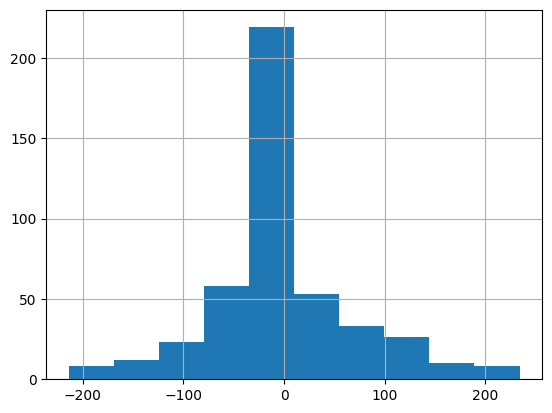

In [43]:
"""
====== modeling with 100% train & no valid =====
[Q1] Q1_weekend_te(1920), Q1_weekend_te2(1106), Q1_new6_te2(251), Q1_new1_te(248), beforebed_통화&전화_앱이용시간(227), sleep_duration_ratio_lag2(220), img1(208), sleep_time_ratio_std3d(200), activehour_메신저_time(186), sleep_duration_min(163)
[Q1] Q1_weekend_te2(0), Q1_new7_te2(0), Q1_weekend_te(0), vacation(0), Q1_new6_te2(0), Q1_new6_te(0), Q1_new7_te(0), Q1_new1_te2(0), Q1_new1_te(0), Q1_new2_te2(0)
[Q2] Q2_new7_te(2332), activehour_screen_time_vs_avg_pct(353), Q2_new2_te(280), wake_time_mean3d(227), walking_minutes(200), beforebed_max_rssi(188), wake_time_diff_lag1(186), Q2_new7_te2(185), Q2_new9_te2(181), activehour_메신저_time(176)
[Q2] Q2_new9_te2(0), Q2_new7_te2(0), Q2_new6_te2(0), Q2_new2_te2(0), Q2_new8_te2(0), Q2_new1_te2(0), Q2_new9_te(0), Q2_new6_te(0), Q2_new2_te(0), m_activity@240min@std@04h00m(0)
[Q3] free_hour_others_ratio(491), Q3_new1_te(400), work_hour_rssi_mean(358), Q3_new2_te(335), light_mean(315), light_night_mean(305), Q3_weekend_te(275), beforebed_scan_count(241), walking_minutes(235), light_weekday(218)
[Q3] Q3_new6_te2(0), Q3_weekend_te2(0), Q3_new2_te2(0), Q3_new8_te2(0), Q3_new6_te(0), Q3_new2_te(0), Q3_new7_te2(0), Q3_weekend_te(0), Q3_new1_te2(0), walking_minutes(0)
[S2] S2_new10_te2(1716), work_hour_unknown_ratio(392), sleep_duration_vs_weekday_avg(372), S2_new9_te(281), img3(238), light_sleep_time_lag1(216), S2_new7_te(208), free_hour_unknown_ratio(206), S2_new1_te(201), activehour_전화_time(198)
[S2] S2_new9_te2(0), S2_new6_te2(0), S2_new9_te(0), S2_new2_te(0), S2_new1_te2(0), S2_new1_te(0), S2_new2_te2(0), S2_new7_te2(0), S2_new7_te(0), S2_new6_te(0)
[S3] S3_new2_te(1937), S3_weekend_te(417), wake_time(400), img3(319), sleep_duration_min_mean3d(291), active_hour_distance_x(268), img4(238), active_hour_high_hr(237), wake_time_mean7d(226), S3_new8_te(197)
[S3] S3_new9_te2(0), S3_weekend_te2(0), S3_new9_te(0), S3_new8_te2(0), S3_new2_te2(0), S3_new7_te2(0), S3_weekend_te(0), S3_new8_te(0), S3_new2_te(0), S3_new6_te2(0)
[S1] beforebed_total_screen_time(645), S1_weekend_te2(627), S1_new2_te2(489), S1_new2_te(468), sleep_duration_min(406), S1_weekend_te(377), rolling_sleep_duration_2d(355), sleep_duration_vs_weekday_avg(350), S1_new8_te(336), sleep_time_d_light_sleep_time(323)
[S1] S1_weekend_te2(0), S1_weekend_te(0), S1_new8_te(0), S1_new8_te2(0), vacation(0), S1_new2_te2(0), sleep_duration_min(0), S1_new7_te2(0), S1_new6_te(0), sleep_duration_ratio(0)
# submission_0.7053748304243852.csv 저장 완료
# submission shape:(250, 9)
==============================
"""
train['sleep_duration_vs_weekday_avg'].hist()

In [44]:
# S1=1: 1.096772786037492
# S1=0: 0.7611056049213945
train['t1'] = np.where(train['sleep_duration_vs_weekday_avg']>0,1,0)
# train['t1'] = np.where(train['sleep_duration_weekday_avg_diff']>0,1,0)
a1 = train.groupby(['subject_id','t1'])['S1'].mean().reset_index()
print(f"# S1=1: {a1.loc[a1['t1']==1,'S1'].mean()}")
print(f"# S1=0: {a1.loc[a1['t1']==0,'S1'].mean()}")
train = train.drop(columns=['t1'])
a1

# S1=1: 1.096772786037492
# S1=0: 0.7611056049213945


,subject_id,t1,S1
0,id01,0,0.7083
1,id01,1,0.7647
2,id02,0,1.1143
3,id02,1,1.6923
4,id03,0,1.0000
5,id03,1,1.2222
6,id04,0,0.7576
7,id04,1,1.1250
8,id05,0,0.4167
9,id05,1,0.9000


### 📦 이전제출과 비교

In [133]:
from pathlib import Path

# Reference file
reference_file = '/content/drive/MyDrive/data/ch2025_data_items/share/submissions/submission_top1_0.6492.csv'
ref_df = pd.read_csv(reference_file)

# Get all CSV files in data directory
data_dir = Path('./')
csv_files = list(data_dir.glob('*.csv'))

# Store differences for each file
differences = []

for csv_file in csv_files:
    if csv_file.name == os.path.basename(reference_file):
        continue

    # Read current file
    current_df = pd.read_csv(csv_file)

    # Calculate differences in specified columns
    diff_count = 0
    for col in ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']:
        diff_count += (ref_df[col] != current_df[col]).sum()

    differences.append((csv_file.name, diff_count))
    # print(f"File: {csv_file.name}, Differences: {diff_count}")

# Sort by difference count and get top 20
differences.sort(key=lambda x: x[1])
print("\nTop 10 files with smallest differences:")
for i, (file_name, diff_count) in enumerate(differences[:50], 1):
    print(f"{str(i).zfill(2)}. {file_name}: {diff_count} differences")


Top 10 files with smallest differences:
01. submission_top8_0.6933.csv: 308 differences
02. submission_top6_0.7215.csv: 312 differences
03. submission_top10_0.7255.csv: 313 differences
04. submission_top9_0.6988.csv: 314 differences
05. submission_top10_0.7215.csv: 314 differences
06. submission_top1_0.7255.csv: 315 differences
07. submission_top8_0.7190.csv: 315 differences
08. submission_top7_0.7207.csv: 316 differences
09. submission_top4_0.7218.csv: 316 differences
10. submission_top3_0.6961.csv: 316 differences
11. submission_top4_0.7265.csv: 316 differences
12. submission_top9_0.7210.csv: 317 differences
13. submission_top9_0.7175.csv: 317 differences
14. submission_top2_0.7218.csv: 318 differences
15. submission_top7_0.7009.csv: 318 differences
16. submission_top8_0.6992.csv: 318 differences
17. submission_top8_0.7210.csv: 319 differences
18. submission_top10_0.6950.csv: 319 differences
19. submission_top5_0.6999.csv: 319 differences
20. submission_top2_0.7031.csv: 319 differen

In [ ]:
import pandas as pd
from scipy.stats import mode

# 데이터 불러오기
a1 = pd.read_csv(f'{path}/submissions/submission_top1_0.6492.csv')
a2 = pd.read_csv(f'{path}/submissions/submission_0.6359383853269983.csv')
a3 = pd.read_csv('./submission_top1_0.7199.csv')

# 병합
rst = pd.concat([a1, a2, a3]).reset_index(drop=True)

# 집계
def aggregate_group(x):
    try:
        s1_mode = mode(x['S1'], keepdims=False).mode
        s1_value = int(s1_mode if not pd.isna(s1_mode) else 0)
    except:
        s1_value = 0  # fallback

    return pd.Series({
        'Q1': int(x['Q1'].mean() > 0.5),
        'Q2': int(x['Q2'].mean() > 0.5),
        'Q3': int(x['Q3'].mean() > 0.5),
        'S1': s1_value,
        'S2': int(x['S2'].mean() > 0.5),
        'S3': int(x['S3'].mean() > 0.5),
    })

# 그룹 적용
rst = (
    rst.groupby(['subject_id', 'sleep_date', 'lifelog_date'])
    .apply(aggregate_group)
    .reset_index()
)

# 저장
rst.to_csv('./submission_final_ensemble.csv', index=False)
rst.head(1)

In [ ]:
rst.loc[:,['Q1','Q2','Q3','S1','S2','S3']].describe().head(2)

In [ ]:
train.loc[:,['Q1','Q2','Q3','S1','S2','S3']].describe().head(2)

### 📦 상관관계 분석

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
a1 = pd.read_csv(f'{path}/submissions/submission_top1_0.6492.csv')
a2 = pd.read_csv(f'{path}/submissions/submission_0.6359383853269983.csv')
a3 = pd.read_csv('./submission_top1_0.7167.csv')

# 공통 Key 기준으로 merge (subject_id, sleep_date, lifelog_date)
df_merged = a1.merge(a2, on=['subject_id', 'sleep_date', 'lifelog_date'], suffixes=('_a1', '_a2'))
df_merged = df_merged.merge(a3, on=['subject_id', 'sleep_date', 'lifelog_date'])

# 마지막 모델 컬럼 이름 수정 (a3용 suffix 추가)
a3_cols = ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']
df_merged.rename(columns={col: f'{col}_a3' for col in a3_cols}, inplace=True)

# 예측값만 추출
pred_cols = [col for col in df_merged.columns if col.startswith(('Q', 'S'))]
corr_matrix = df_merged[pred_cols].corr()

# plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=0.0, vmax=1.0)
plt.title('Model Predictions Correlation (a1, a2, a3)')
plt.show()